# Linear Factor Models

## Load Packages and Extra Functions

In [1]:
using Printf, LinearAlgebra, Statistics, DelimitedFiles

include("src/printmat.jl")
include("src/CovNW.jl")
include("src/Ols.jl")
include("src/OlsSure.jl")

OlsSure

In [2]:
"""
    meanV(x)

Calculate the sample average of each column of `x` and return a vector of them.

"""
meanV(x) = vec(mean(x,dims=1))


"""
    hKron(X,Y)

Calculate a `Txnk` matrix where row `t` is kron(X[t,:],Y[t,:]) and where
`X` is `Txn` and `Y` is `Txk`.

Does the same as
```
g = fill(NaN,T,size(F,2)*n)
for t in 1:T
  g[t,:] = kron(F[t:t,:],ε[t:t,:])
end
```

"""
function hKron(X,Y)
  T = size(X,1)
  Z = reshape( reshape(X,T,1,:).*Y,T,: )
  return Z
end

hKron

In [3]:
using Plots

gr(size=(480,320))
default(fmt = :png)

## Loading Data

In [4]:
xx   = readdlm("Data/FFmFactorsPs.csv",',',skipstart=1)
(Rme,RSMB,RHML,Rf) = [xx[:,i] for i=2:5]   #market, small minus big, high minus low, riskfree

xx = readdlm("Data/FF25Ps.csv",',')  #no header line: x is matrix
R  = xx[:,2:end]                     #returns for 25 FF portfolios
Re = R .- Rf                         #excess returns for the 25 FF portfolios
xx = nothing

(T,n) = size(Re)                     #no. obs and  no. test assets

(388, 25)

# Testing alpha from Time Series Regressions

With $n$ test assets and $K$ excess return factors, the linear factor model is

$
R_{t}^{e}=\alpha+\beta f_{t}+\varepsilon_{t},
$

and the testable hypothesis is that all alphas are zero. 

The next cell gets point estimates from OLS and the following cell uses them in a GMM setup. (The GMM setup is here mostly to get a direct comparison with the later cross-sectional approach.)

In [5]:
F      = [ones(T) Rme RSMB RHML]          #factors, constant and 3 FF factors
FNames = ["c","Rme","RSMB","RHML"]        #names, used for printing
K      = size(F,2) - 1                    #no. factors, excl. the constanz

(b,ε,) = OlsGM(Re,F)                      #point estimates and residuals
α      = b[1,:]                           #n vector
β      = b[2:end,:]'                      #nxK matrix
println()

The setup in the next cell follows the GMM approach in the lecture notes where the moment conditions are like

$ 
g_t = 
\begin{bmatrix} 1\\ f_t \end{bmatrix} \otimes \epsilon_t,
$

where $\epsilon_t$ is an $n$-vector of regression residuals, one for each test asset. The parameters so that the $\alpha$ vector are the first $n$ elements.

In [6]:
g    = hKron(F,ε)                         #Txn(1+K), moment conditions
S₀   = CovNW(g,0,1)                     #Var(sqrt(T)*gbar)
D₀_1 = -kron(inv(F'F/T),I(n))             #inverse of Jacobian
V    = D₀_1*S₀*D₀_1'                      #covariance matrix(all coeffs)

WaldStat = α'inv(V[1:n,1:n]/T)*α          #test if all alpha=0

printblue("Testing α = 0:")
printmat(Any[WaldStat,length(α),34.38],rowNames=["test statistic","df","10% critical value"])

Testing α = 0:
test statistic       162.011
df                    25    
10% critical value    34.380



In [7]:
gbar = meanV(g)

printblue("The (average) sample moment conditions are (reshaped as n x (1+K)):\n")
colNames = [string("ϵ*",i) for i in FNames]
rowNames = [string("asset ",i) for i=1:n]
printmat(reshape(gbar,n,K+1);colNames,rowNames)

The (average) sample moment conditions are (reshaped as n x (1+K)):

               ϵ*c     ϵ*Rme    ϵ*RSMB    ϵ*RHML
asset 1     -0.000    -0.000    -0.000    -0.000
asset 2     -0.000    -0.000    -0.000     0.000
asset 3     -0.000    -0.000    -0.000     0.000
asset 4     -0.000    -0.000    -0.000     0.000
asset 5     -0.000     0.000    -0.000     0.000
asset 6      0.000     0.000     0.000    -0.000
asset 7      0.000     0.000    -0.000    -0.000
asset 8     -0.000    -0.000    -0.000     0.000
asset 9     -0.000     0.000    -0.000     0.000
asset 10    -0.000    -0.000    -0.000    -0.000
asset 11    -0.000    -0.000    -0.000     0.000
asset 12     0.000     0.000     0.000    -0.000
asset 13    -0.000     0.000    -0.000     0.000
asset 14    -0.000    -0.000    -0.000     0.000
asset 15    -0.000    -0.000    -0.000     0.000
asset 16    -0.000    -0.000    -0.000    -0.000
asset 17    -0.000    -0.000    -0.000     0.000
asset 18     0.000     0.000    -0.000    -0.000


# Time Series Approach as a Standard OLS/SURE Problem (extra)

The next cell redoes the the previous analysis but using a standard OLS/SURE approach. It is virtually identical, except that the code structures the parameters and moment conditions in another order (regression 1 first, then regression 2, etc).

In [8]:
(b,_,_,V,_) = OlsSure(Re,F,true,0)      #estimates and covariance matrix
αNew = b[1,:]                             #n vector

v = 1:(K+1):length(b)                     #indices of α in b: 1,(K+1)+1,2(K+1)+1,...
WaldStat = αNew'inv(V[v,v])*αNew          #test if all α=0

printblue("Testing α = 0:")
printmat(WaldStat,rowNames=["test statistic"])

Testing α = 0:
test statistic   162.011



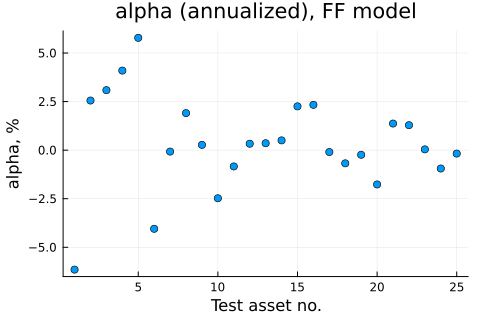

In [9]:
scatter( α*12,
         legend = false,
         title = "alpha (annualized), FF model",
         xlabel = "Test asset no.",
         ylabel = "alpha, %" )

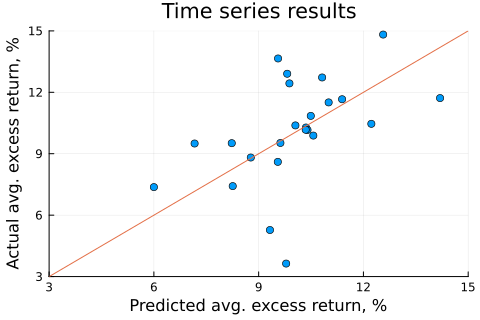

In [10]:
ERe     = meanV(Re)           #n vector, average excess returns
EF      = meanV(F[:,2:end])   #K vector, average values of factors
ReHatTS = β*EF                #predicted average returns, setting alpha=0

scatter( ReHatTS*12,ERe*12,
         legend = false,
         xlims = (3,15),
         ylims = (3,15),
         title = "Time series results",
         xlabel = "Predicted avg. excess return, %",
         ylabel = "Actual avg. excess return, %" )

plot!([0;20],[0,20])

# Cross-Sectional Regressions

The following code from uses GMM to test $\operatorname*{E}R^{e}=\beta \lambda$ from an FF model applying the method for "General Factors".

(The factors happen to be excess returns,
but that does not stop us from applying the method for general factors.) 

The code applies GMM without a weighting function. Instead, an $A$ matrix is defined
such that $A\bar{g}=\mathbf{0}$ becomes the effective moment conditions. The
matrix is chosen to make the factor risk premia ($\lambda$) the same as in the
old-fashioned cross-sectional regressions.

## Getting the Point Estimates

In [11]:
(b,ε,) = OlsGM(Re,F)

ERe = meanV(Re)
β   = b[2:end,:]'                #nxK
θ   = β'
λ,  = OlsGM(θ*ERe,θ*β)           #cross-sectional estimate of price of factor risk

printblue("Fitted risk premia and sample averages (*12):\n")
printmat([λ EF]*12,colNames=["λ","Ef"],rowNames=FNames[2:end])

printred("large differences casts doubts on the cross-sectional regression")

Fitted risk premia and sample averages (*12):

             λ        Ef
Rme      6.800     7.223
RSMB     3.026     2.500
RHML     5.269     3.960

large differences casts doubts on the cross-sectional regression


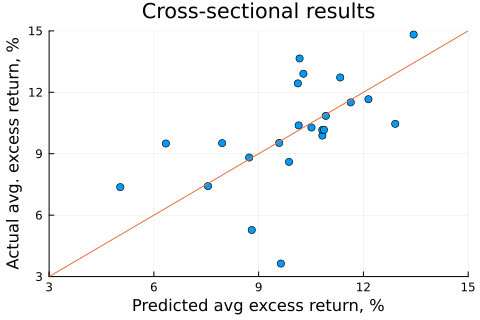

In [12]:
ReHatCR = β*λ   #predicted average returns, setting alpha=0

p1 = scatter( ReHatCR*12,ERe*12,
              legend = false,
              xlims = (3,15),
              ylims = (3,15),
              title = "Cross-sectional results",
              xlabel = "Predicted avg excess return, %",
              ylabel = "Actual avg. excess return, %" )
plot!([0;20],[0,20])
display(p1)

## Comparing the Cross-Sectional and Time-Series Results

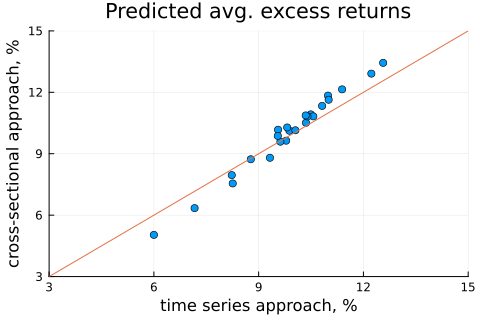

In [13]:
p1 = scatter( ReHatTS*12,ReHatCR*12,
              legend = false,
              xlim = (3,15),
              ylim = (3,15),
              title = "Predicted avg. excess returns",
              xlabel = "time series approach, %",
              ylabel = "cross-sectional approach, %" )
plot!([0;20],[0,20])
display(p1)

## Testing the Cross-Sectional Results

In [14]:
g = hKron(F,ε)                             #moment conditions, regressors*residual
g = hcat(g,Re .- (β*λ)')                   #moment conditions, Txq

p = length(α) + length(β) + length(λ)       #no. parameters
q = size(g,2)                               #no. moment conditions

gbar = meanV(g)

printblue("The (average) sample moment conditions are (reshaped as n x (1+K+1)):\n")
colNames = [[string("ϵ*",i) for i in FNames];"Re-βλ"]
rowNames = [string("asset ",i) for i=1:n]
printmat(reshape(gbar,n,K+2);colNames,rowNames)   # ; since keywords with same name

The (average) sample moment conditions are (reshaped as n x (1+K+1)):

               ϵ*c     ϵ*Rme    ϵ*RSMB    ϵ*RHML     Re-βλ
asset 1     -0.000    -0.000    -0.000    -0.000    -0.500
asset 2     -0.000    -0.000    -0.000     0.000     0.193
asset 3     -0.000    -0.000    -0.000     0.000     0.219
asset 4     -0.000    -0.000    -0.000     0.000     0.290
asset 5     -0.000     0.000    -0.000     0.000     0.411
asset 6      0.000     0.000     0.000    -0.000    -0.294
asset 7      0.000     0.000    -0.000    -0.000    -0.019
asset 8     -0.000    -0.000    -0.000     0.000     0.116
asset 9     -0.000     0.000    -0.000     0.000    -0.040
asset 10    -0.000    -0.000    -0.000    -0.000    -0.302
asset 11    -0.000    -0.000    -0.000     0.000    -0.011
asset 12     0.000     0.000     0.000    -0.000     0.020
asset 13    -0.000     0.000    -0.000     0.000    -0.006
asset 14    -0.000    -0.000    -0.000     0.000    -0.011
asset 15    -0.000    -0.000    -0.000     0

In [15]:
S₀   = CovNW(g,0,1)
D₀LL = kron([0 λ'],I(n))             #lower left of D₀
D₀   = - [kron(F'F/T,I(n)) zeros(n*(1+K),K);
          D₀LL             β           ]

A    = [I     zeros(n*(1+K),n);
        zeros(K,n*(1+K)) θ ]

Ψₐ = I - D₀*inv(A*D₀)*A
Ψ₃ = Ψₐ*S₀*Ψₐ'                              #Cov[sqrt(T)*gbar], rank q-p
WaldStat  = gbar'pinv(Ψ₃/T)*gbar            #test of moment conditions

printblue("\nTesting ERe = βλ:")
printmat(Any[WaldStat,(q-p),30.81],rowNames=["test statistic","df","10% critical value"])


Testing ERe = βλ:
test statistic       155.261
df                    22    
10% critical value    30.810



# Fama-MacBeth Approach

In [16]:
b, = OlsGM(Re,F)             #point estimates
β  = b[2:end,:]'             #nxK matrix

K = size(β,2)
T = size(Re,1)

388

In [17]:
(λ,ϵ) = (fill(NaN,T,K),fill(NaN,T,n))
for t in 1:T                         #loop over time periods
    (λ_t,ϵ_t,) = OlsGM(Re[t,:],β)    #same as β\Re[t,:]
    λ[t,:] = λ_t                     #estimated coefficients
    ϵ[t,:] = ϵ_t                     #residuals
end

In [18]:
avg_λ = meanV(λ)            #time-averages
avg_ϵ = meanV(ϵ)

var_avg_ϵ = vec(var(ϵ,dims=1)/T)       #variances of the time averages
var_avg_λ = vec(var(λ,dims=1)/T)

printblue("\nTime averages of FMB estimates (*12):\n")
xut = [avg_λ sqrt.(var_avg_λ)]*12
printmat(xut,colNames=["λ","Std(λ)"],rowNames=FNames[2:end])

printred("Compare the λ estimates from cross-sectional (above) and FMB")


Time averages of FMB estimates (*12):

             λ    Std(λ)
Rme      6.800     2.904
RSMB     3.026     2.263
RHML     5.269     2.034

Compare the λ estimates from cross-sectional (above) and FMB


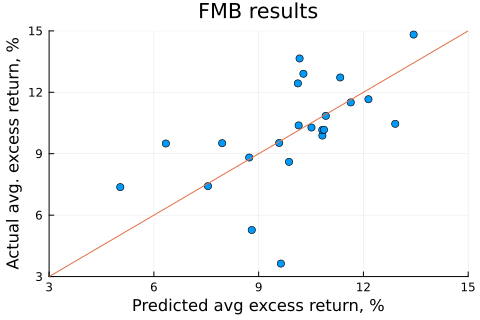

In [19]:
ReHatFMB = β*avg_λ   #predicted average returns

p1 = scatter( ReHatFMB*12,ERe*12,
              legend = false,
              xlim = (3,15),
              ylim = (3,15),
              title = "FMB results",
              xlabel = "Predicted avg excess return, %",
              ylabel = "Actual avg. excess return, %" )
plot!([0;20],[0,20])
display(p1)